In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = sns.color_palette("Set2")[0]  # e.g. unweighted sample
COL_WEIGHTED = sns.color_palette("Set2")[1]  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [3]:
VISUALIZE_SURFACE = False

In [4]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/neuroaging/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [5]:
metric = "adc"
distribution_metric = "qfmean"
data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


data["age_squared"] = data["age_at_scan"] ** 2
data["sex"] = data["sex"].map({"M": 0, "F": 1})

/tmp/ipykernel_257803/2526694603.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [6]:
metric_col = "volume" if metric == "gm_vol" else distribution_metric

In [7]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [8]:
import numpy as np
import pandas as pd


# ─────────────────────────────────────────────────────────────────────────────
def compute_poststrat_weights(
    sample_df: pd.DataFrame,
    pop_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    start_col: str = "range_start",
    end_col: str = "range_end",
    pop_total_col: str = "total",
    cap: float | None = None,
    return_bin_table: bool = False,
):
    """
    Post-stratification weights so that the age distribution of *sample_df*
    matches an external population distribution supplied in *pop_df*.

    Parameters
    ----------
    sample_df : DataFrame with an ``age_col`` column (years; int or float).
    pop_df    : DataFrame with columns
                    [start_col, end_col, pop_total_col].
                * Values in ``pop_total_col`` can be counts **or** percentages
                  (they are internally re-scaled to proportions).
                * The row order doesn’t matter; they will be sorted.
    cap       : Optional float.  If provided, weights are truncated at
                ``cap × mean(weight)`` and then re-scaled so mean(weight)=1.
    return_bin_table : If True, also return a DataFrame summarising
                       n_sample, n_pop, and weight_factor for every bin.

    Returns
    -------
    weights   : 1-D numpy array aligned with ``sample_df.index``.
    bin_table : (optional) tidy per-bin summary (see above).
    """

    # 1 ── tidy & validate the population table --------------------------------
    pop = (
        pop_df[[start_col, end_col, pop_total_col]]
        .dropna()
        .astype({start_col: int, end_col: int, pop_total_col: float})
        .sort_values(start_col)  # your CSV is descending; fix that
        .reset_index(drop=True)
    )

    if (pop[end_col] <= pop[start_col]).any():
        raise ValueError("Each range_end must exceed range_start.")

    if (pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values).any():
        overlap = pop.iloc[
            np.where(pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values)[0] + 1
        ][[start_col, end_col]]
        raise ValueError(
            "Age bins overlap (rows shown below) — "
            "merge / correct them before weighting:\n"
            f"{overlap}"
        )

    # 2 ── build right-inclusive bin edges  (···| s_i  …  e_i | s_{i+1} …) ----
    edges = pop[start_col].tolist() + [pop[end_col].iloc[-1]]

    # 3 ── assign every participant to a bin -----------------------------------
    s_bins = pd.cut(
        sample_df[age_col],
        bins=edges,
        right=True,
        include_lowest=True,
        labels=pop.index,  # categorical labels 0,1,…
    )

    # 4 ── compute *sample* and *population* proportions per bin --------------
    n_sample = s_bins.value_counts(sort=False).sort_index()
    prop_sample = n_sample / n_sample.sum()

    prop_pop = pop[pop_total_col] / pop[pop_total_col].sum()

    # 5 ── weight factor = pop_prop / sample_prop ------------------------------
    weight_factor = prop_pop / prop_sample.replace(0, np.nan)  # avoid /0 → NaN

    # 6 ── map factor back to each row ----------------------------------------
    w = s_bins.map(weight_factor).astype(float).to_numpy()
    w = np.where(np.isnan(w), 0.0, w)  # rows that fell outside bins → 0

    # 7 ── optional weight truncation (winsorisation) --------------------------
    if cap is not None and cap > 0:
        mean_pos = w[w > 0].mean()
        w = np.clip(w, 0, cap * mean_pos)

    # 8 ── re-scale so mean(weight > 0) == 1 -----------------------------------
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    # 9 ── return --------------------------------------------------------------
    if return_bin_table:
        bin_tbl = pd.DataFrame(
            {
                "n_sample": n_sample,
                "n_pop": prop_pop * n_sample.sum(),  # rescaled to sample size
                "prop_sample": prop_sample,
                "prop_pop": prop_pop,
                "weight_factor": weight_factor,
            }
        )
        return w, bin_tbl

    return w

In [9]:
# assign weights
data["weight"], _ = compute_poststrat_weights(
    data,
    israel_population,
    age_col="age_at_scan",
    cap=None,  # try None first; if still spiky, use 4 or 5
    return_bin_table=True,
)

In [10]:
from tqdm import tqdm
# Set up dataframes to store results

models = {}

for save_name in ["lin_unw", "lin_w", "quad_unw", "quad_w", "unw_compare", "w_compare"]:
    models[save_name] = pd.read_pickle(OUTPUT_DIR.with_name("fig2") / f"{save_name}_{metric}.pkl")



In [11]:
# Tell the pipeline which side of the parabola is “structural stabilisation”
orientation = {           # feel free to expand
    "gm_vol" : "max",      # concave-down expected
    "adc"    : "min",      # concave-up expected
    # "fa"   : "min",
    # "rd"   : "min",
}

def vertex_age(beta1, beta2):
    """Age at vertex of a quadratic   β0 + β1·x + β2·x²."""
    return -beta1 / (2 * beta2)

def stabilisation_age(metric, betas, *, age_min=18, age_max=85):
    """
    betas = dict with keys "age" (β1) and "age_sq" (β2)
    Returns (age*, flagged)   where flagged=True if outside range or wrong shape.
    """
    want = orientation.get(metric, "min")       # default = 'min' if not listed
    β1, β2 = betas["age"], betas["age_sq"]

    # ── 1. Shape check  ────────────────────────────────────────────────
    if   want == "min" and β2 <= 0:
        # parabola opens down – no minimum inside; flag & push to boundary
        return age_min, True
    elif want == "max" and β2 >= 0:
        # parabola opens up – no maximum inside
        return age_max, True

    # ── 2. Compute vertex  ─────────────────────────────────────────────
    age_star = vertex_age(β1, β2)
    clipped  = False

    # clip to observed age window
    if age_star < age_min:
        age_star, clipped = age_min, True
    elif age_star > age_max:
        age_star, clipped = age_max, True

    return age_star, clipped


In [12]:
alpha = 0.000005
use_quad = models["w_compare"]["p_corrected"] < alpha

stab_df = parcels.copy()

age_min = np.nan

for i, row in parcels.iterrows():
    lm = models["lin_w"].loc[i,"model"]
    qm = models["quad_w"].loc[i,"model"]
    p = models["w_compare"].loc[i, "p_corrected"]
    if p < alpha and qm.params["age_squared"] != 0:
        β1 = qm.params["age_at_scan"]
        β2 = qm.params["age_squared"]
        age_star, clipped = stabilisation_age(metric, {"age": β1, "age_sq": β2})
        chosen = "quadratic"
    else:
        age_star = age_min                     # or age_max / np.nan
        clipped   = False
        chosen    = "linear"

    
    # Save the results
    stab_df.loc[i, "age_star"] = age_star
    stab_df.loc[i, "clipped"] = clipped
    stab_df.loc[i, "chosen"] = chosen
    stab_df.loc[i, "p"] = p
    stab_df.loc[i, "β1"] = β1 if chosen=="quadratic" else lm.params["age_at_scan"]
    stab_df.loc[i, "β2"] = β2 if chosen=="quadratic" else 0.0
    stab_df.loc[i, "r2_lin"] = lm.rsquared_adj
    stab_df.loc[i, "r2_quad"] = qm.rsquared_adj

In [13]:
stab_df[stab_df["clipped"] == False].sort_values("age_star", ascending=False).head(20)

,index,name,base_name,Label Name,network,component,hemisphere,age_star,clipped,chosen,p,β1,β2,r2_lin,r2_quad
413,414,PUT-DA-rh,PUT-DA,"Putamen, dorso-anterior part",subcortex,Putamen,R,55.957622,False,quadratic,4.046007e-16,-0.000003,2.646630e-08,0.030586,0.062170
412,413,PUT-VA-rh,PUT-VA,"Putamen, ventro-anterior part",subcortex,Putamen,R,55.595896,False,quadratic,2.033628e-22,-0.000002,2.066899e-08,0.036254,0.081041
415,416,PUT-DP-rh,PUT-DP,"Putamen, dorso-posterior part",subcortex,Putamen,R,54.103076,False,quadratic,8.907058e-18,-0.000003,3.095851e-08,0.036461,0.071393
426,427,aGP-rh,aGP,"Pallidum, anterior part",subcortex,Pallidum,R,53.842908,False,quadratic,1.901007e-08,-0.000004,4.108471e-08,0.009714,0.025075
423,424,NAc-shell-rh,NAc-shell,"Nucleus Accumbens, shell",subcortex,Nucleus Accumbens,R,53.167680,False,quadratic,6.156658e-41,-0.000003,2.963362e-08,0.029798,0.113565
439,440,PUT-VA-lh,PUT-VA,"Putamen, ventro-anterior part",subcortex,Putamen,L,52.939843,False,quadratic,2.276913e-30,-0.000003,2.834024e-08,0.028288,0.090273
442,443,PUT-DP-lh,PUT-DP,"Putamen, dorso-posterior part",subcortex,Putamen,L,52.059687,False,quadratic,1.128058e-10,-0.000002,2.352558e-08,0.018634,0.038710
440,441,PUT-DA-lh,PUT-DA,"Putamen, dorso-anterior part",subcortex,Putamen,L,49.793722,False,quadratic,9.783332e-18,-0.000003,2.585343e-08,0.004858,0.040840
450,451,NAc-shell-lh,NAc-shell,"Nucleus Accumbens, shell",subcortex,Nucleus Accumbens,L,47.575736,False,quadratic,2.481058e-65,-0.000004,4.474722e-08,0.003106,0.139137
441,442,PUT-VP-lh,PUT-VP,"Putamen, ventro-posterior part",subcortex,Putamen,L,46.296451,False,quadratic,9.628687e-18,-0.000003,2.783010e-08,0.007809,0.043702


In [14]:
stab_df.sort_values("age_star", ascending=True)

,index,name,base_name,Label Name,network,component,hemisphere,age_star,clipped,chosen,p,β1,β2,r2_lin,r2_quad
59,60,7Networks_LH_SomMot_29,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,18.0,True,quadratic,2.751461e-12,1.000638e-05,-6.675473e-08,0.176638,0.196439
60,61,7Networks_LH_SomMot_30,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,18.0,True,quadratic,8.721295e-15,-1.705989e-06,5.321205e-08,0.263441,0.285249
62,63,7Networks_LH_SomMot_32,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,18.0,True,quadratic,5.417772e-08,6.469953e-06,-4.762352e-08,0.066865,0.080395
61,62,7Networks_LH_SomMot_31,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,18.0,True,quadratic,8.456796e-37,1.506250e-05,-1.301585e-07,0.091510,0.161992
52,53,7Networks_LH_SomMot_22,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,18.0,True,quadratic,8.175015e-11,-1.286931e-06,7.783672e-08,0.282598,0.297498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,391,7Networks_RH_Default_PFCdPFCm_13,7networks_rh_default_pfcdpfcm,7Networks_RH_Default_PFCdPFCm,default,dorsal prefrontal cortex medial prefrontal cortex,R,NaN,False,linear,5.433786e-01,2.232753e-07,0.000000e+00,0.004604,0.004307
408,409,THA-VPl-rh,THA-VPl,"Thalamus, lateral ventro-posterior part",subcortex,Thalamus,R,NaN,False,linear,1.038686e-02,2.926015e-07,0.000000e+00,0.051905,0.054666
425,426,pGP-rh,pGP,"Pallidum, posterior part",subcortex,Pallidum,R,NaN,False,linear,2.716940e-02,1.479181e-06,0.000000e+00,0.038151,0.040115
452,453,pGP-lh,pGP,"Pallidum, posterior part",subcortex,Pallidum,L,NaN,False,linear,4.880132e-05,-7.822358e-08,0.000000e+00,-0.000731,0.007215


In [15]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

if VISUALIZE_SURFACE:    
    surfaces = fetch_fslr()
    lh, rh = surfaces['inflated']
    p = Plot(lh, rh)

    # add schaefer parcellation (no color bar needed)
    lh_parc, rh_parc = load_parcellation('schaefer')
    p.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=True)

    p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
                as_outline=True, cbar=False)
    fig = p.build()
    fig.show()

In [16]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation

if VISUALIZE_SURFACE:
    
    atlas_img = nib.load(nifti_matlab)

    # ---------------------------------------------------------------------
    # 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
    # ---------------------------------------------------------------------
    surfaces = fetch_fslr()
    lh, rh = surfaces["veryinflated"]


    # ---------------------------------------------------------------------
    # 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
    # ---------------------------------------------------------------------
    # add schaefer parcellation (no color bar needed)
    lh_parc, rh_parc = load_parcellation("schaefer")

In [17]:
if VISUALIZE_SURFACE:
    # ---------------------------------------------------------------------
    # 4.  MAP REGION IDs → METRIC VALUES
    #     vertices with label 0 (background) → NaN so they render transparent
    # ---------------------------------------------------------------------
    p_threshold = 0.05
    value_threshold = 0

    value_map = {}
    value_map_subcortex = {"region":[],"value":[],"Hemisphere":[]}

    vis_df = stab_df
    value_column = "age_star"

    for i, row in vis_df.iterrows():
        label = row[region_col]
        value = row[value_column]
        # if (row["p_corrected"] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
        if row["clipped"]:
            value = np.nan
        # else:
        #     value = np.nan
        if "schaefer" in ATLAS:
            if label > int(ATLAS.split("_")[1]):
                value_map_subcortex["region"].append(label)
                value_map_subcortex["value"].append(value)
                value_map_subcortex["Hemisphere"].append(row["hemisphere"])
            else:
                value_map[label] = value

    vec = np.vectorize(lambda x: value_map.get(x, np.nan))
    data_lh = vec(lh_parc)
    data_rh = vec(rh_parc)

In [18]:
if VISUALIZE_SURFACE:
    vmin = 18
    vmax = 45

    for hemi, hemi_data, key, vis_data in zip(["L","R"],[lh,rh], ["left","right"], [data_lh, data_rh]):
        # ---------------------------------------------------------------------
        # 5.  BUILD THE PLOT
        # ---------------------------------------------------------------------
        p = Plot(
            hemi_data,
            # rh,
            # views="latmed",  # L-lat, L-med, R-lat, R-med
            size=(800, 300),  # px; change as needed
            zoom=1.6,
            layout="row",
            mirror_views=True,
            views=["medial","lateral"]
        )

        # ---- main data layer -------------------------------------------------
        # If your metric is centred on 0 (e.g., t-values) use TwoSlopeNorm for symmetry
        # norm = TwoSlopeNorm(
        #     vmin=np.nanmin([data_lh, data_rh]), ,vmax=np.nanmax([data_lh, data_rh])
        # )

        p.add_layer(
            {"left": data_lh, "right": data_rh},
            cmap="Purples",
            color_range=(vmin,vmax),
            # color_range=(2.5,3.5),
            cbar_label=value_column,
        )
        # ---- outline layer ---------------------------------------------------
        # Re-use the label arrays; surfplot draws borders when as_outline=True
        p.add_layer({"left": lh_parc, "right": rh_parc}, cmap="gray", as_outline=True, cbar=False)


        # fig = p.build(cbar_kws=dict(location="bottom", decimals=2))
        fig = p.build()

        # save figure
        savefig_nice(fig, OUTPUT_DIR / f"fig3_{metric}_{hemi}_{value_column}.png", dpi=400)

In [19]:
if VISUALIZE_SURFACE:
    from subcortex_visualization.plotting import plot_subcortical_data

    subcort_df = pd.DataFrame(value_map_subcortex)
    if "schaefer" in ATLAS:
        subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


    for hemi in ["L","R"]:

        fig = plot_subcortical_data(
            subcort_df,
            atlas="Melbourne_S3",
            show_legend=True,
            hemisphere=hemi,
            cmap="Purples",
            line_color="black",
            line_thickness=2,
            vmin = vmin,
            vmax = vmax,
            show_figure=False
        )

        # save figure
        savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib import font_manager as fm

# template colour palette
COL_GREY = "#575A5C"  # primary charcoal (axes / default bars)
COL_TEAL = "#21A0A0"  # accent / second category
COL_GRID = "#E5E5E5"  # light gridlines
COL_SAME = "#D81B60"  # Deep pink/magenta
# COL_SAME = COL_GREY
# COL_DIFF_REP = "#1E88E5"  # Blue for diff subj (repeated)
COL_DIFF_REP = COL_TEAL
# COL_DIFF_SINGLE = "#43A047"  # Green for diff subj (single)
COL_DIFF_SINGLE = COL_GREY  # Green for diff subj (single)

# AGE star color (sort of purple)
COL_AGE_STAR = "#9C27B0"  # Purple for age star


# ══ 0. Register the font  ═══════════════════════════════════════════
CUSTOM_FONT = "/home/galkepler/.fonts/Mulish-Regular.ttf"  # or Quicksand

if Path(CUSTOM_FONT).exists():
    fm.fontManager.addfont(CUSTOM_FONT)
    plt.rcParams["font.family"] = fm.FontProperties(fname=CUSTOM_FONT).get_name()
else:
    print("⚠ Custom font not found – falling back to default.")

plt.rcParams.update(
    {
        "font.size": 14,
        "axes.labelcolor": COL_GREY,
        "xtick.color": COL_GREY,
        "ytick.color": COL_GREY,
        "axes.edgecolor": COL_GRID,
    }
)
sns.set_style("whitegrid", {"axes.edgecolor": COL_GRID})  # light grid
plt.rcParams["font.family"] = fm.FontProperties(fname=CUSTOM_FONT).get_name()

In [52]:
from matplotlib.cm import ScalarMappable
import seaborn as sns
import mpmath


def high_precision_pvalue(model, dps=3):
    """
    Calculate high-precision p-value for an F-statistic using mpmath.

    Parameters:
    - f_stat: F-statistic from your model
    - df_num: numerator degrees of freedom (e.g., df_model)
    - df_den: denominator degrees of freedom (e.g., df_resid)
    - dps: decimal places of precision (default 50)

    Returns:
    - High-precision p-value (mpmath.mpf type)
    """
    mpmath.mp.dps = dps

    r2 = model.rsquared_adj
    n = model.nobs
    x = (-np.sqrt(r2) + 1) / 2  # shift per `loc=-1`, scale per `scale=2`
    pval_mpmath = 2 * mpmath.mp.betainc(n / 2 - 1, n / 2 - 1, 0, x, regularized=True)
    str_p = str(pval_mpmath)
    if "e" in str_p:
        p_int = str_p.split("e")[0].ljust(4, "0")

        p_exp = str_p.split("e")[1]
        p_vis = f"{p_int} \\times 10^{{{p_exp}}}"
    else:
        p_vis = f"{float(str_p):.3f}"
    return pval_mpmath, p_vis

In [87]:
import statsmodels.api as sm

# ------------------------------------------------------------------
def plot_weighted_age_fit(
    df_long,
    metric_name,
    age_star,
    *,
    weight_col="weight",
    sex_col="sex",
    tiv_col="tiv",
    alpha_pts=0.5,
    s_pts=100,
    out_png=None,
):
    """
    df_long : long-format dataframe that contains
              ['subject_code','value','age_at_scan','sex','tiv',
               'age_squared','weight','metric']   (metric column optional)
    metric_name : the metric (e.g. 'GM_volume' or 'MD') to filter on

    Saves a PNG if out_png is supplied, else just returns the figure.
    """
    # --- subset metric ---------------------------------------------------
    if "metric" in df_long.columns:
        d = df_long[df_long["metric"] == metric_name].copy()
    else:
        # assume df already only contains that metric
        d = df_long.copy()

    # --- design matrices -------------------------------------------------
    # predictors for linear
    X_lin = d[["age_at_scan"]].copy()
    # add sex dummy
    X_lin["sex"] = pd.get_dummies(d[sex_col], drop_first=True).astype(int).values
    # add TIV only for GM volume
    if metric_name.lower().startswith("gm"):
        X_lin["tiv"] = d[tiv_col]
    X_lin = sm.add_constant(X_lin)

    # predictors for quadratic
    X_quad = X_lin.copy()
    X_quad["age_squared"] = d["age_squared"]

    y = d["value"].astype(float)
    w = d[weight_col].astype(float)
    # --- weighted fits ----------------------------------------------------
    mod_lin = sm.WLS(y, X_lin, weights=w).fit()
    mod_quad = sm.WLS(y, X_quad, weights=w).fit()

    # --- prediction grid --------------------------------------------------
    age_grid = np.linspace(d["age_at_scan"].min(), d["age_at_scan"].max(), 250)
    # ------------------------------------------------------------------
    # build a DataFrame that has **exactly** the columns mod_lin expects
    cols = mod_lin.model.exog_names  # e.g. ['const','age_at_scan','sex','tiv']

    pred_lin_df = pd.DataFrame(
        {c: 0 for c in cols}, index=range(len(age_grid))  # start with zeros
    )
    pred_lin_df["age_at_scan"] = age_grid  # fill the age column
    pred_lin_df["const"] = 1  # statsmodels always needs the constant

    # For GM models, 'tiv' exists in cols → leave its zeros or set to median:
    if "tiv" in pred_lin_df.columns:
        pred_lin_df["tiv"] = d["tiv"].median()

    # For the dummy‑coded sex column (whatever its name), keep zeros = baseline sex.
    pred_lin = mod_lin.predict(pred_lin_df)

    _, pval_lin = high_precision_pvalue(mod_lin)
    # convert from e to x10

    # ---------- quadratic model (same trick) -------------------------
    cols_q = mod_quad.model.exog_names
    pred_quad_df = pd.DataFrame({c: 0 for c in cols_q}, index=range(len(age_grid)))
    pred_quad_df["age_at_scan"] = age_grid
    if "age_squared" in pred_quad_df.columns:
        pred_quad_df["age_squared"] = age_grid**2
    pred_quad_df["const"] = 1
    if "tiv" in pred_quad_df.columns:
        pred_quad_df["tiv"] = d["tiv"].median()

    pred_quad = mod_quad.predict(pred_quad_df)

    _, pval_quad = high_precision_pvalue(mod_quad)
    # ---------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

    # scatter (weighted points)
    sizes = (w / w.max()) * s_pts * 3  # size ~ weight
    ax.scatter(
        d["age_at_scan"],
        y,
        s=sizes,
        alpha=alpha_pts,
        color="#575A5C",
        edgecolors="none",
    )

    # curves
    ax.plot(
        age_grid,
        pred_lin,
        color="#D81B60",
        lw=4,
        alpha=alpha_pts,
        label=f"Linear  $R^2={mod_lin.rsquared:.2f}, p<{pval_lin}$",
    )
    ax.plot(
        age_grid,
        pred_quad,
        color="#1E88E5",
        lw=8,
        label=f"Quadratic  $R^2={mod_quad.rsquared:.2f}, p<{pval_quad}$",
    )
    ax.tick_params(axis="both", labelsize=26)

    # add vertical line at age_star
    lab = f"Age of Stabilization = {age_star:.1f} years"
    if age_star <= 18:
        lab += " (or earlier)"
    ax.axvline(
        age_star,
        color=COL_AGE_STAR,
        linestyle="--",
        lw=4,
        label=lab
    )

    # Cosmetics
    if metric_name.lower().startswith("gm"):
        title = "GM Volume"
        # format y-axis to scientific notation
        # scale = 1_000
        # ax.yaxis.set_major_formatter(
        #     plt.FuncFormatter(lambda x, _: f"{x / scale:.0f}"))
        # set y-axis limits
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
        ax.set_ylabel("GM volume (mm³)", fontsize=30)
    elif metric_name.lower().startswith("adc"):
        # ser exponent style y axis
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
        ax.set_ylabel("MD (mm²/s)", fontsize=30)
        title = "MD"
    elif metric_name.lower().startswith("ad"):
        # ser exponent style y axis
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
        ax.set_ylabel("AD (mm²/s)", fontsize=30)
        title = "AD"
    # ax.set_title(title, fontsize=30, pad=12)
    ax.set_xlabel("Age (years)", fontsize=30)
    # ax.set_ylabel(metric_name)
    ax.grid(axis="y", color="#E5E5E5", lw=0.6)
    ax.set_axisbelow(True)
    ax.legend(
        frameon=False,
        fontsize=28,
        # loc="upper right"
        )

    fig.tight_layout()
    if out_png:
        fig.savefig(out_png, dpi=300, transparent=True)
        print(f"▶ saved to {out_png}")
    return fig, mod_lin, mod_quad

In [111]:
v = stab_df.copy()
v = v.loc[:401]
v[v["clipped"] == True].sort_values(["p"], ascending=False).head(50)

,index,name,base_name,Label Name,network,component,hemisphere,age_star,clipped,chosen,p,β1,β2,r2_lin,r2_quad
352,353,7Networks_RH_Cont_PFCl_13,7networks_rh_cont_pfcl,7Networks_RH_Cont_PFCl,control,lateral prefrontal cortex,R,18.0,True,quadratic,3.323343e-06,6.030443e-08,3.193580e-08,0.237286,0.245300
282,283,7Networks_RH_DorsAttn_Post_13,7networks_rh_dorsattn_post,7Networks_RH_DorsAttn_Post,dorsal attention,posterior,R,18.0,True,quadratic,1.785535e-06,6.901581e-07,4.604258e-08,0.294950,0.302777
248,249,7Networks_RH_SomMot_19,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,18.0,True,quadratic,1.241156e-06,-6.826865e-07,3.104487e-08,0.161506,0.171109
228,229,7Networks_RH_Vis_29,7networks_rh_vis,7Networks_RH_Vis,visual,visual,R,18.0,True,quadratic,1.235419e-06,-1.065760e-06,3.096662e-08,0.118620,0.128721
313,314,7Networks_RH_SalVentAttn_Med_4,7networks_rh_salventattn_med,7Networks_RH_SalVentAttn_Med,salience / ventral attention,medial,R,18.0,True,quadratic,1.147016e-06,3.751163e-06,-2.940789e-08,0.035617,0.046740
389,390,7Networks_RH_Default_PFCdPFCm_12,7networks_rh_default_pfcdpfcm,7Networks_RH_Default_PFCdPFCm,default,dorsal prefrontal cortex medial prefrontal cortex,R,18.0,True,quadratic,8.673812e-07,-5.083271e-08,2.664181e-08,0.241560,0.250511
11,12,7Networks_LH_Vis_12,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,6.615524e-07,-4.079144e-07,1.854276e-08,0.166182,0.176241
287,288,7Networks_RH_DorsAttn_Post_18,7networks_rh_dorsattn_post,7Networks_RH_DorsAttn_Post,dorsal attention,posterior,R,18.0,True,quadratic,4.239939e-07,4.935529e-06,-3.973371e-08,0.030673,0.042784
73,74,7Networks_LH_DorsAttn_Post_6,7networks_lh_dorsattn_post,7Networks_LH_DorsAttn_Post,dorsal attention,posterior,L,18.0,True,quadratic,3.631936e-07,-9.839613e-08,2.864750e-08,0.247528,0.257043
51,52,7Networks_LH_SomMot_21,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,18.0,True,quadratic,3.563916e-07,3.866699e-06,-3.015890e-08,0.046237,0.058318


▶ saved to /home/galkepler/Projects/neuroaging/figures/fig3/fig3_adc_sommot_L_62.png


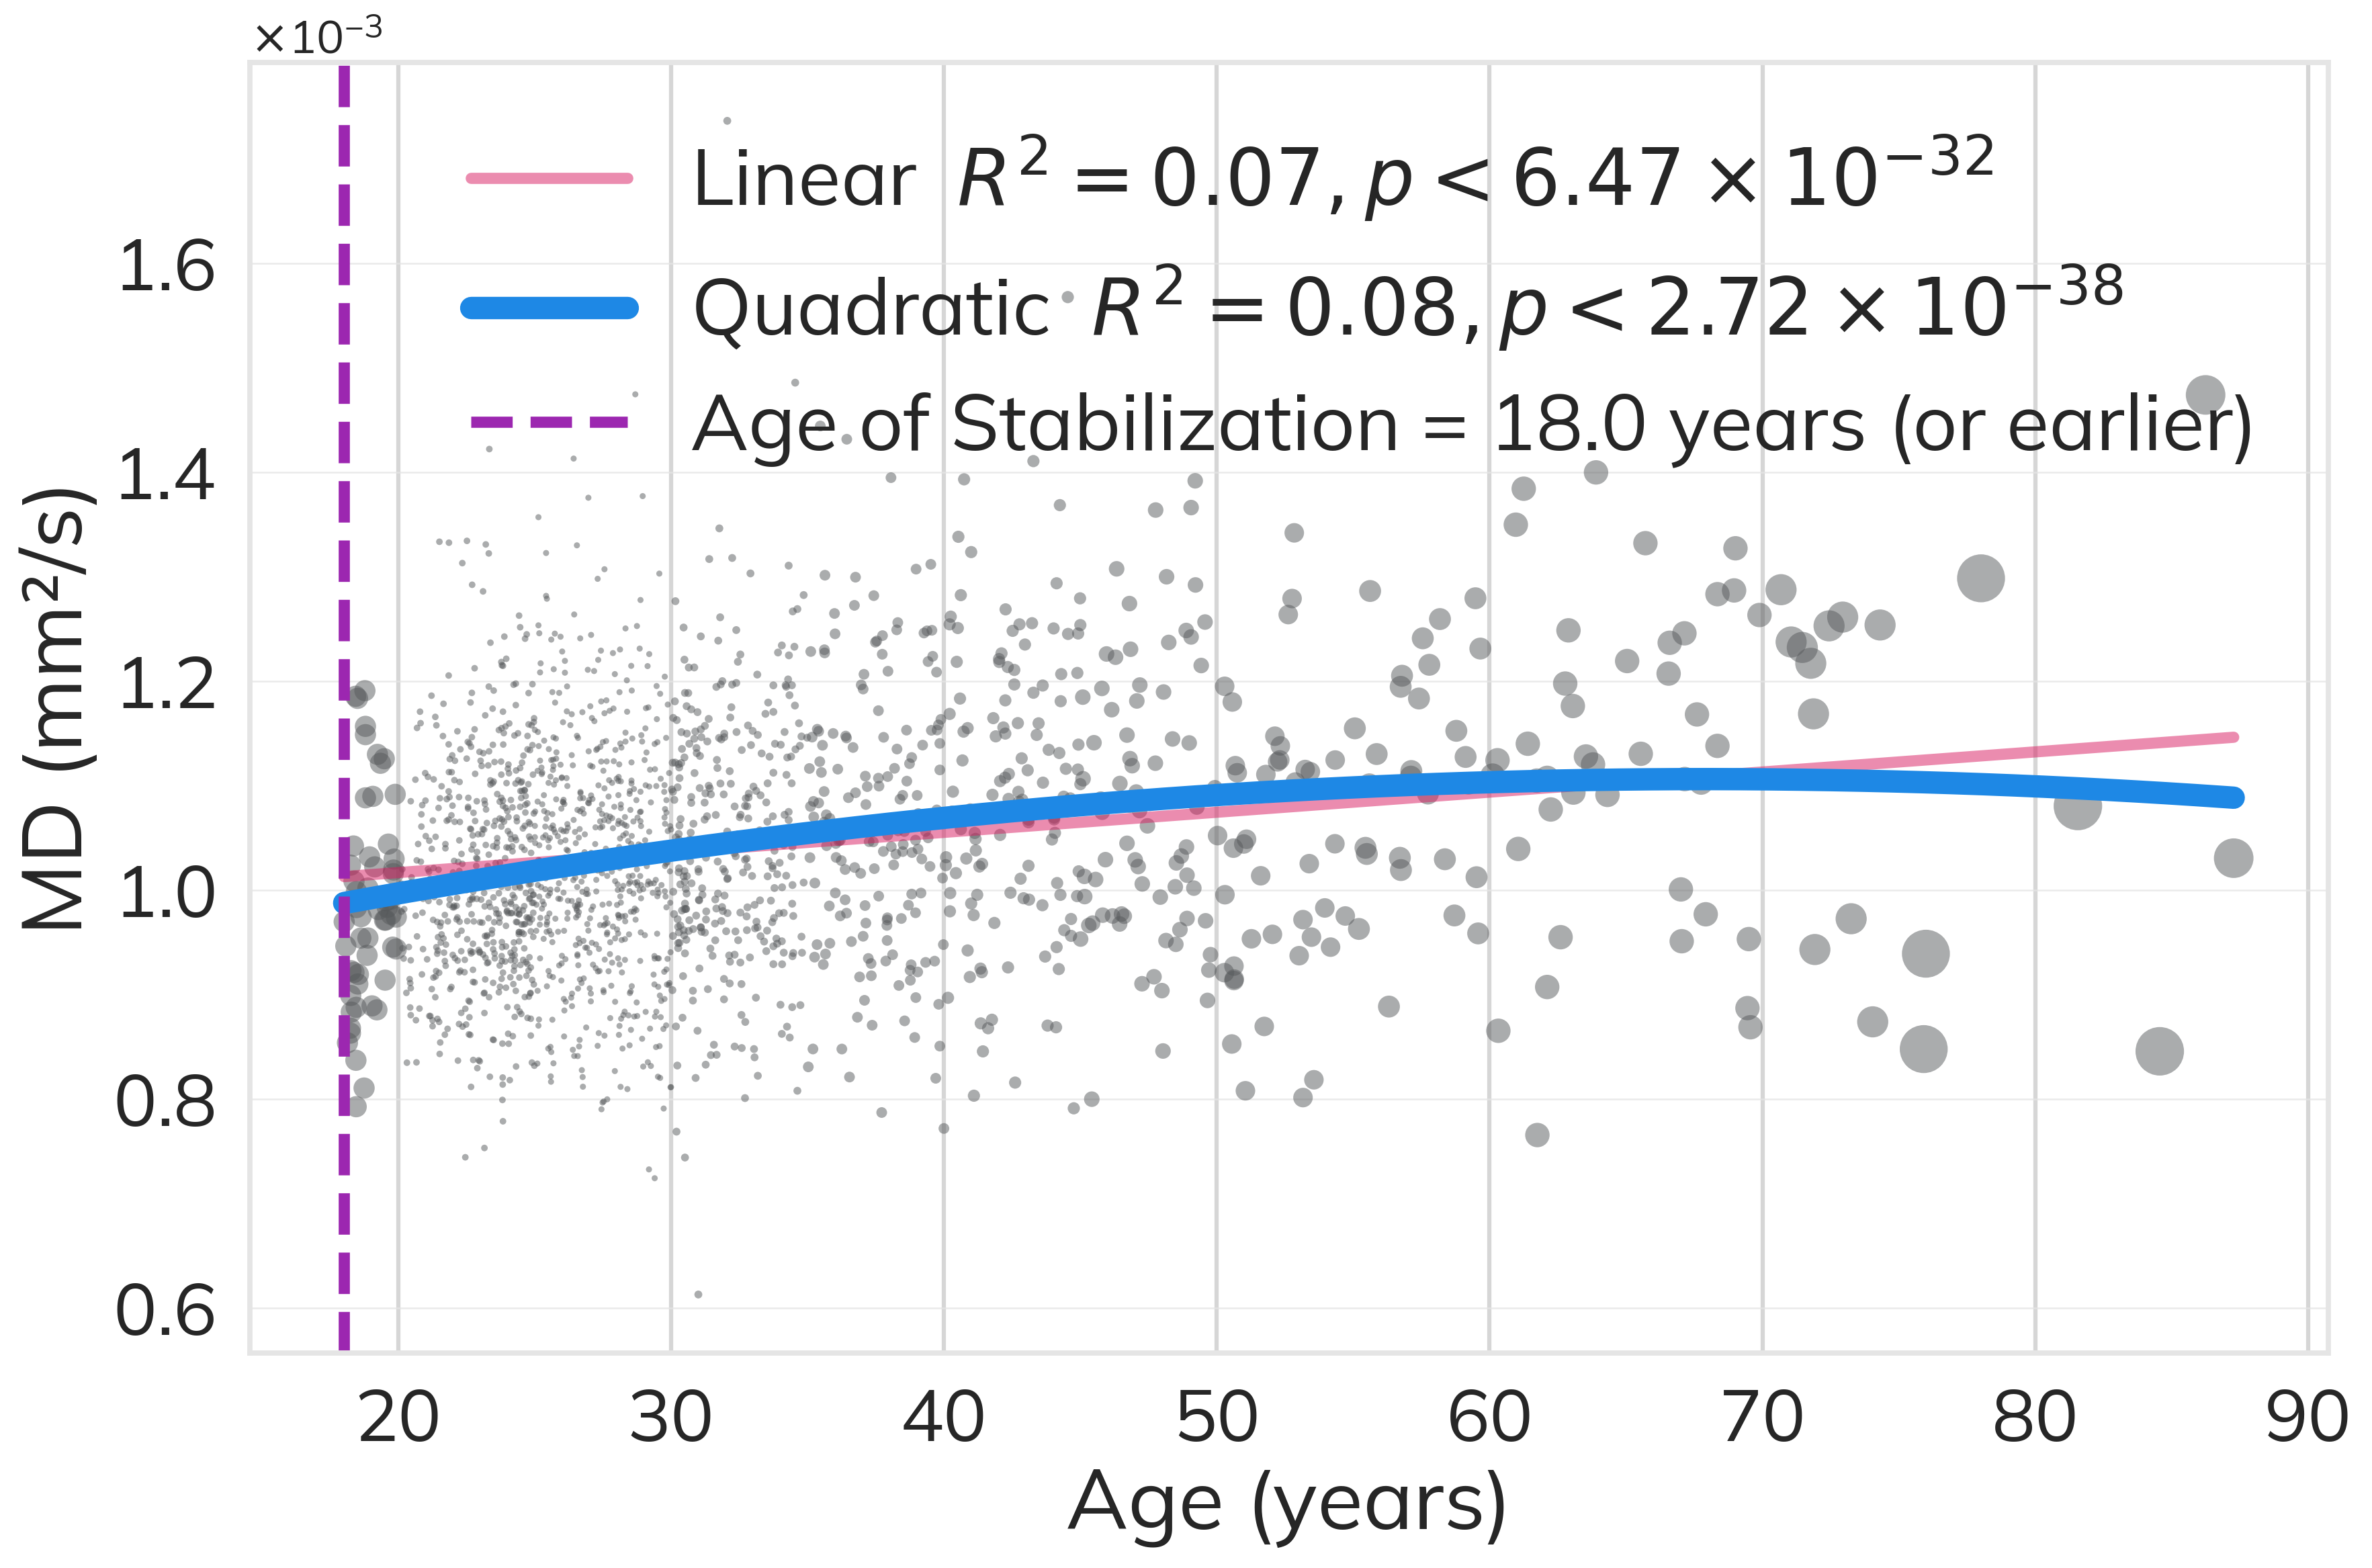

In [112]:
i = 62

age_star = stab_df.loc[i, "age_star"]

covariates = ["sex"]
if metric == "gm_vol":
    covariates.append("tiv")

d = data[data[region_col] == parcels.loc[i, region_col]].copy()
d.rename(columns={metric_col: "value"}, inplace=True)

fig, mod_lin, mod_quad = plot_weighted_age_fit(
    d,
    metric,
    age_star,
    out_png=OUTPUT_DIR / f"fig3_{metric}_sommot_L_{i}.png",
)

In [104]:
parcels.loc[168]

index                                169
name          7Networks_LH_Default_PFC_4
base_name       7networks_lh_default_pfc
Label Name      7Networks_LH_Default_PFC
network                          default
component              prefrontal cortex
hemisphere                             L
Name: 168, dtype: object